This notebook creates and then trains naive templates

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [16]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [17]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [5]:
def log_norm(x,mode,sigma):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1e5/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return f1(x)/f1(10000)

N = 20
n = 6
modes  = np.concatenate((np.linspace(5500,4600,n,endpoint=False),np.linspace(4600,1000,N-n)))
sigmas = np.concatenate((np.linspace(0.35,0.56,n,endpoint=False),np.linspace(0.56, 0.9,N-n)))

# save the templates as Seds
x = np.linspace(10,15000,100)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i])#,As[i])
    naive_templates["naive"+str(i+1)] = template

Create training sets and plot them

In [6]:
%%time
training_sets = create_training_sets(naive_templates,galaxies,bandpass_dict)

CPU times: user 5min 3s, sys: 149 ms, total: 5min 3s
Wall time: 5min 3s


Number of fluxes in each training set:
[81331, 62842, 42287, 37963, 34612, 33542, 35018, 35154, 28953, 22312, 16139, 10529, 7564, 7092, 8860, 11050, 15407, 22095, 38543, 63135]


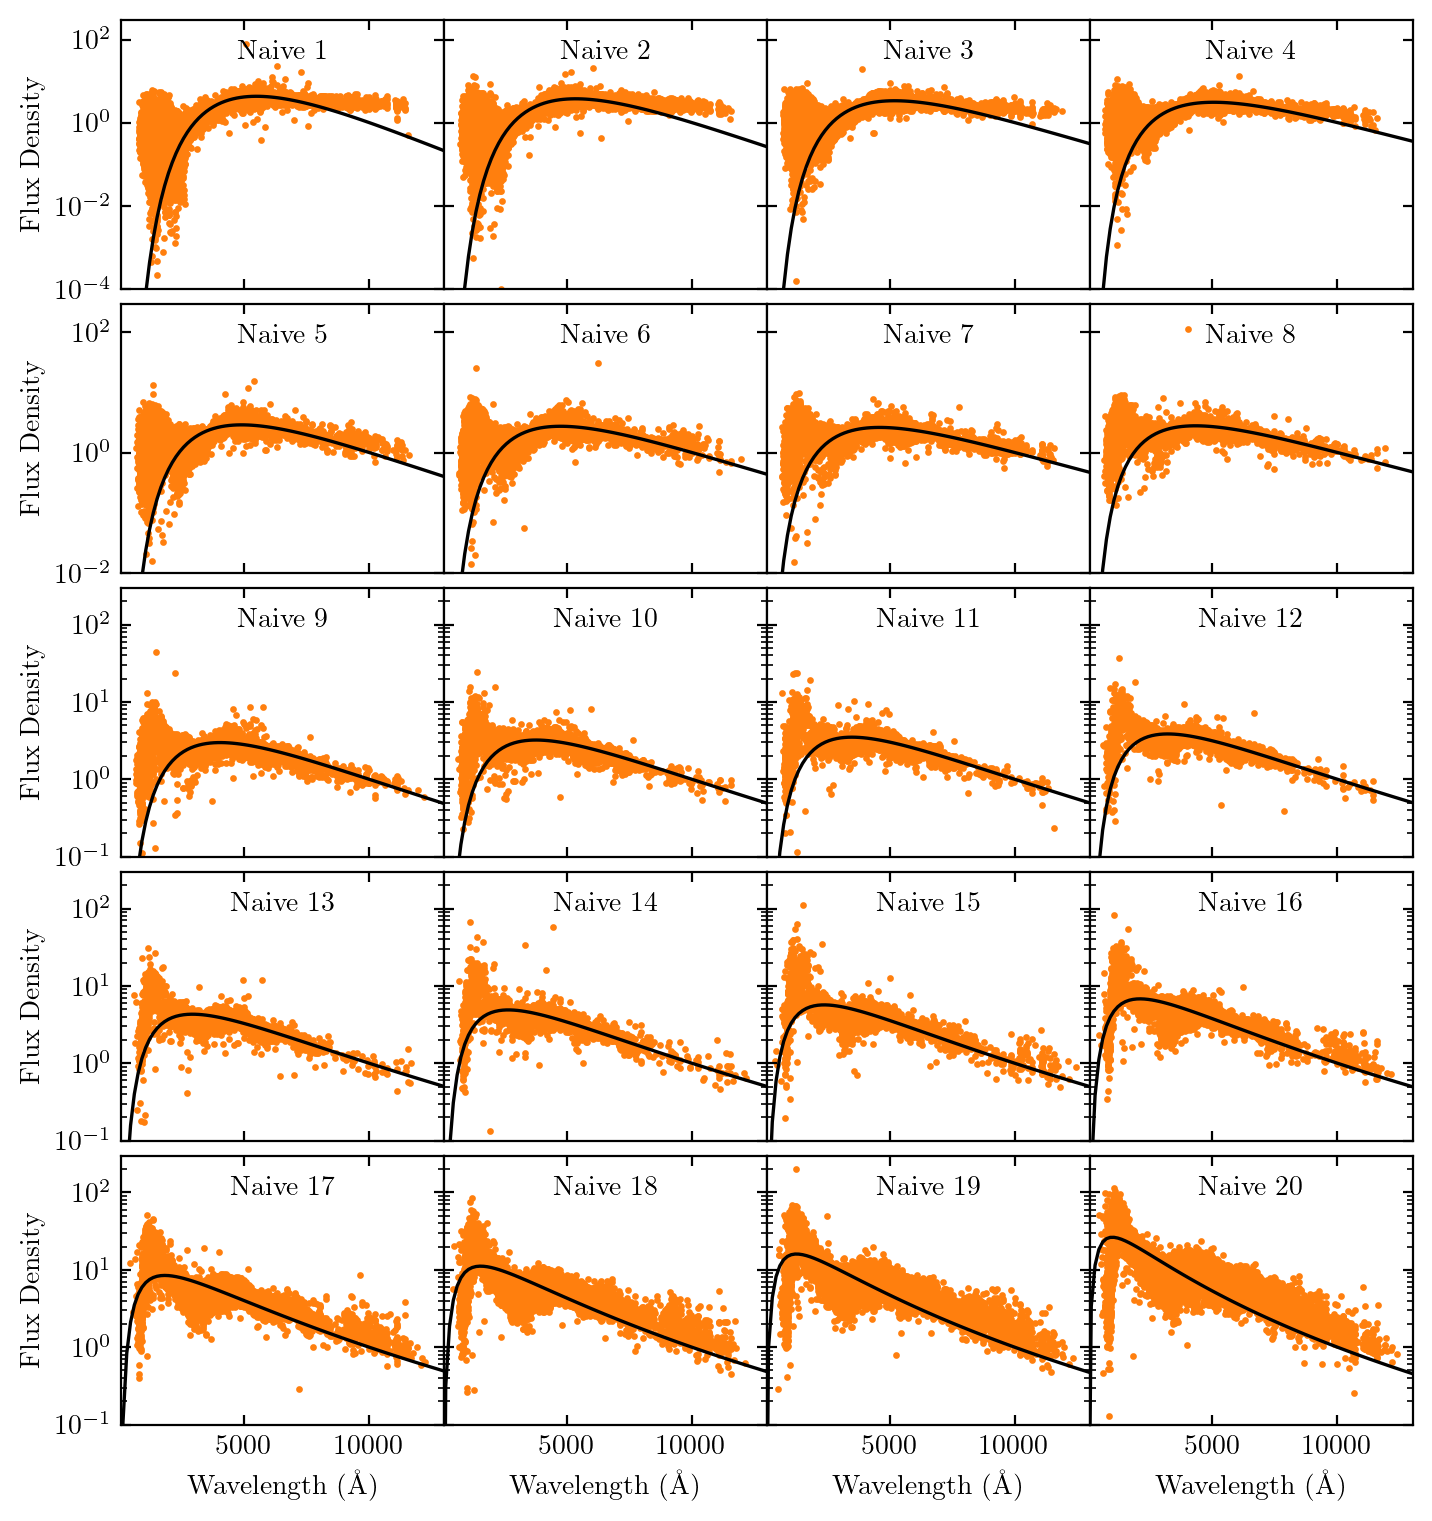

In [18]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.85))

print("Number of fluxes in each training set:")
print([len(i) for i in training_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in training_sets["naive"+str(i+1)]]
    fluxes  = [row[1] for row in training_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = naive_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="-", c="k")
    
    ax.text(0.5,0.85,"Naive "+str(i+1),transform=ax.transAxes,ha="center")
    
    ax.set_xlim(100,13000)
    ax.set_yscale('log')
    

axes[0,0].set_ylim(0.0001,300)
axes[1,0].set_ylim(0.01,300)
axes[2,0].set_ylim(0.1,300)
axes[3,0].set_ylim(0.1,300)
axes[4,0].set_ylim(0.1,300)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/naive_untrained.pdf')

Now train the templates

In [19]:
%%time
trained_templates, final_sets = train_templates(naive_templates, galaxies, bandpass_dict, N_iter=1, w=0.5)

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Generating final sets
Done!
CPU times: user 45min 13s, sys: 6.33 s, total: 45min 19s
Wall time: 41min 1s


Plot the trained templates

Number of fluxes in each training set:
[82723, 50224, 42544, 35724, 36525, 31104, 33620, 33743, 23891, 12646, 9213, 9120, 9527, 24338, 28283, 25370, 15668, 31133, 42191, 36841]


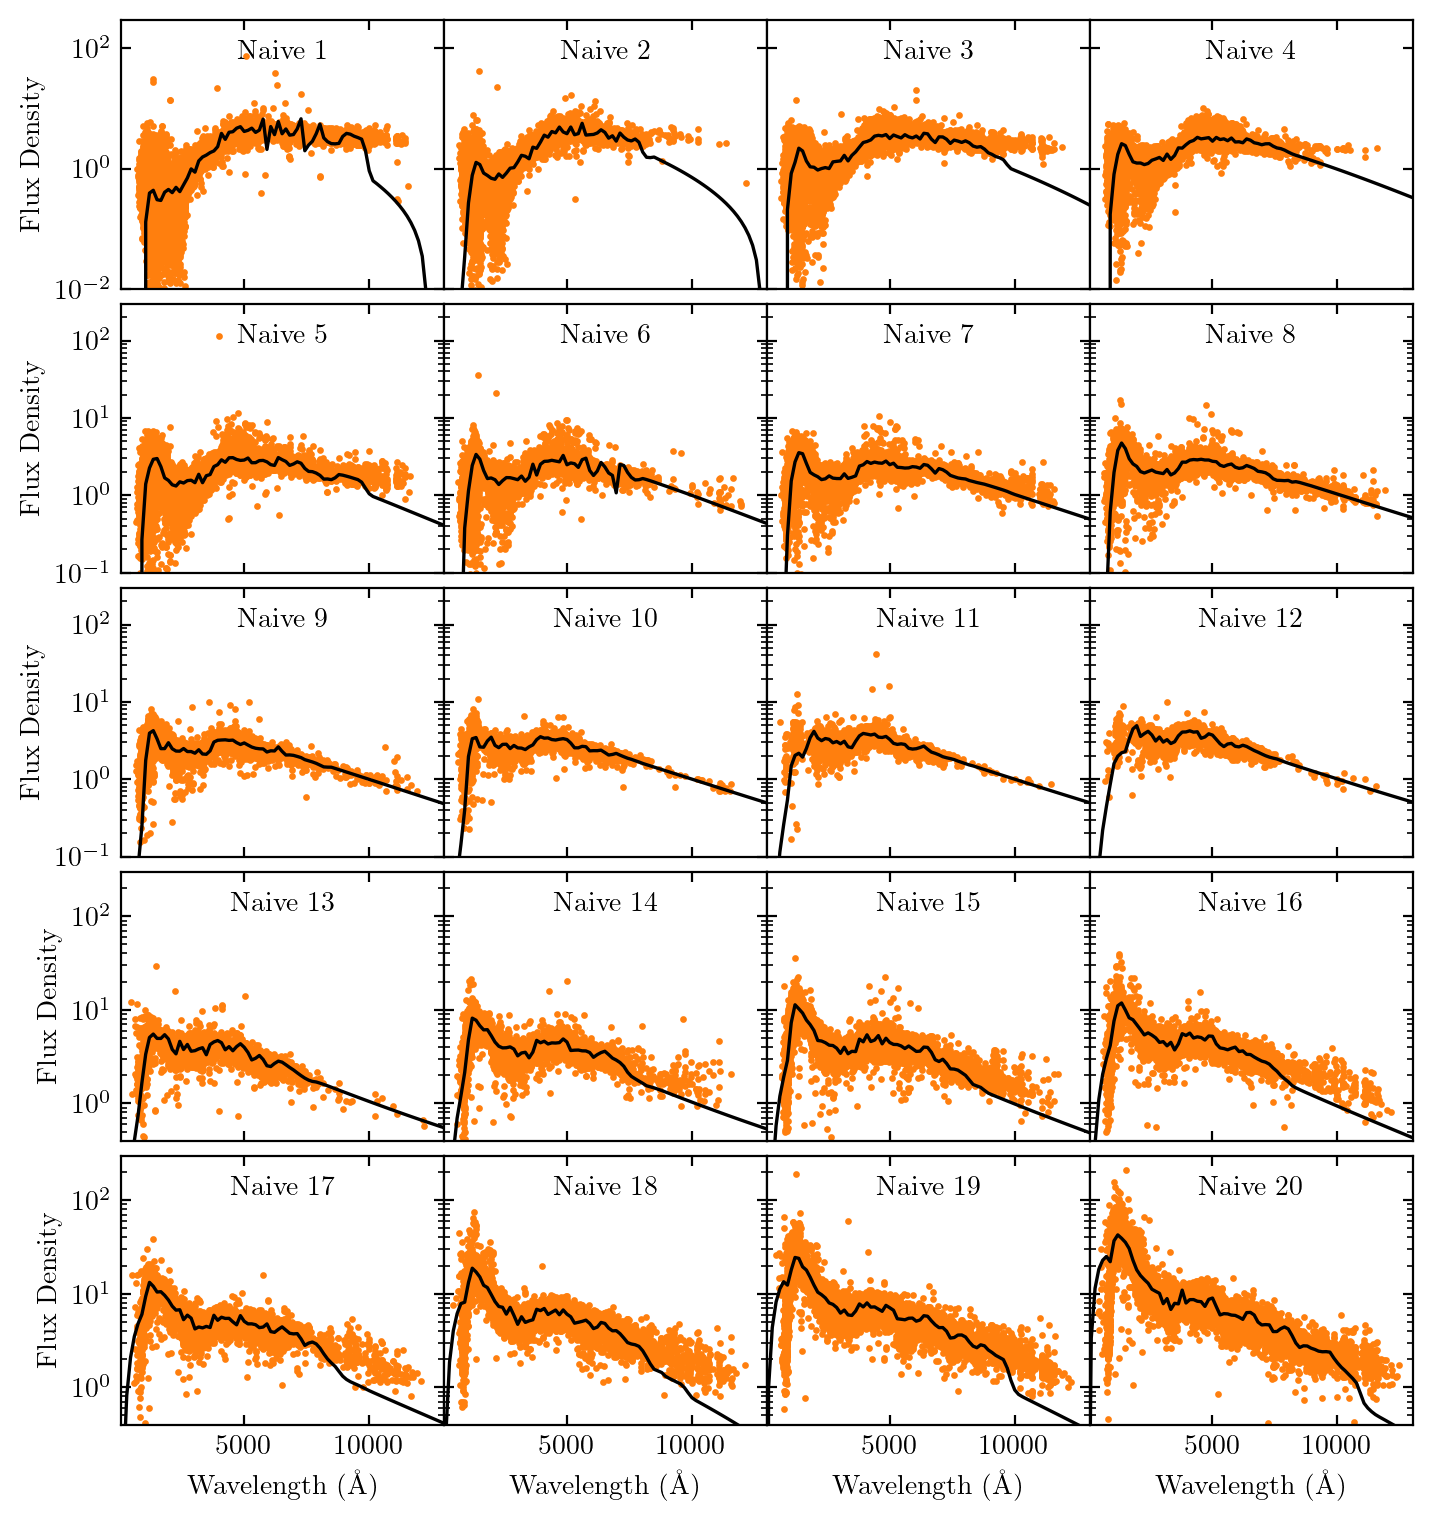

In [20]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.85))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in final_sets["naive"+str(i+1)]]
    fluxes  = [row[1] for row in final_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="-", c="k")
    
    ax.text(0.5,0.85,"Naive "+str(i+1),transform=ax.transAxes,ha="center")
    
    ax.set_xlim(100,13000)
    ax.set_yscale('log')
    

axes[0,0].set_ylim(0.01,300)
axes[1,0].set_ylim(0.1,300)
axes[2,0].set_ylim(0.1,300)
axes[3,0].set_ylim(0.4,300)
axes[4,0].set_ylim(0.4,300)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/naive_trained.pdf')

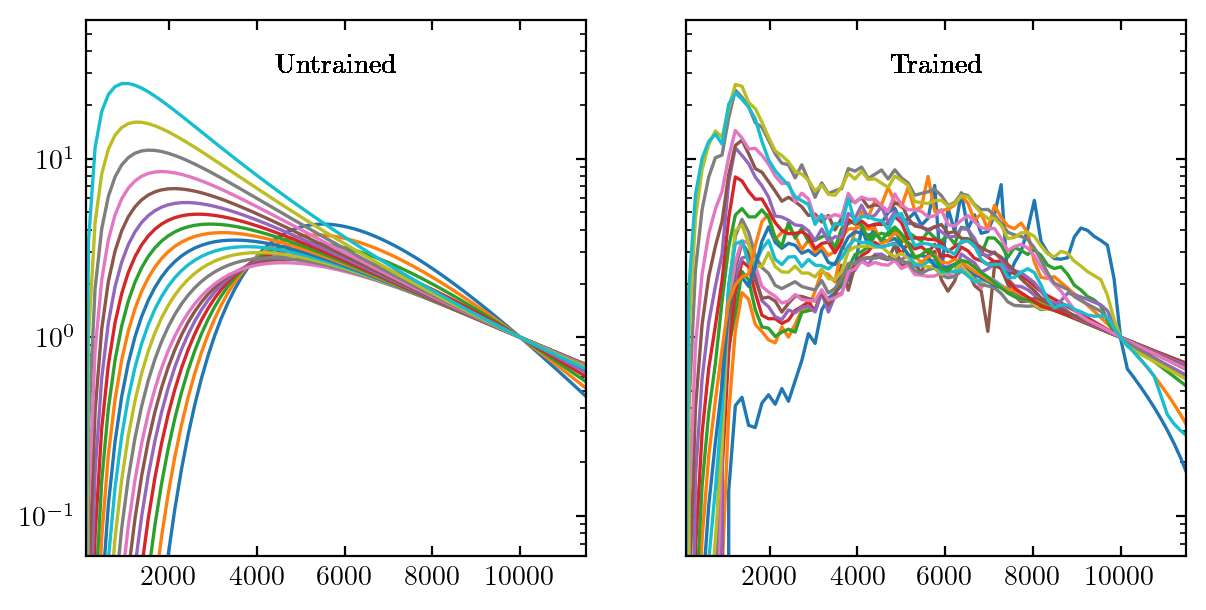

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex='all',sharey='all',figsize=(twocol,twocol/2))

# plot the untrained templates
for template in naive_templates.values():
    
    # normalize them at 10,000 angstroms
    scale = np.interp(10000,template.wavelen,template.flambda)
    ax1.plot(template.wavelen,template.flambda/scale)
    
    ax1.text(0.5,0.9,"Untrained",transform=ax1.transAxes,ha="center")

for template in trained_templates.values():
    
    # normalize them at 10,000 angstroms
    scale = np.interp(10000,template.wavelen,template.flambda)
    ax2.plot(template.wavelen,template.flambda/scale)
    
    ax2.text(0.5,0.9,"Trained",transform=ax2.transAxes,ha="center")
    
plt.yscale('log')
plt.ylim(0.06,60)
plt.xlim(100,11500)
plt.show()

Save the results!

In [11]:
for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = trained_templates[template].wavelen
    y = trained_templates[template].flambda
    for i in range(len(x)):
        file.write("{0:<10.2f}{1:<10.2f}\n".format(x[i],y[i]))
    file.close()

Plot the naive templates with the CWW+SB4 Templates

In [12]:
cwwsb4 = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'Im_B2004a', 'SB3_B2004a', 
                'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']

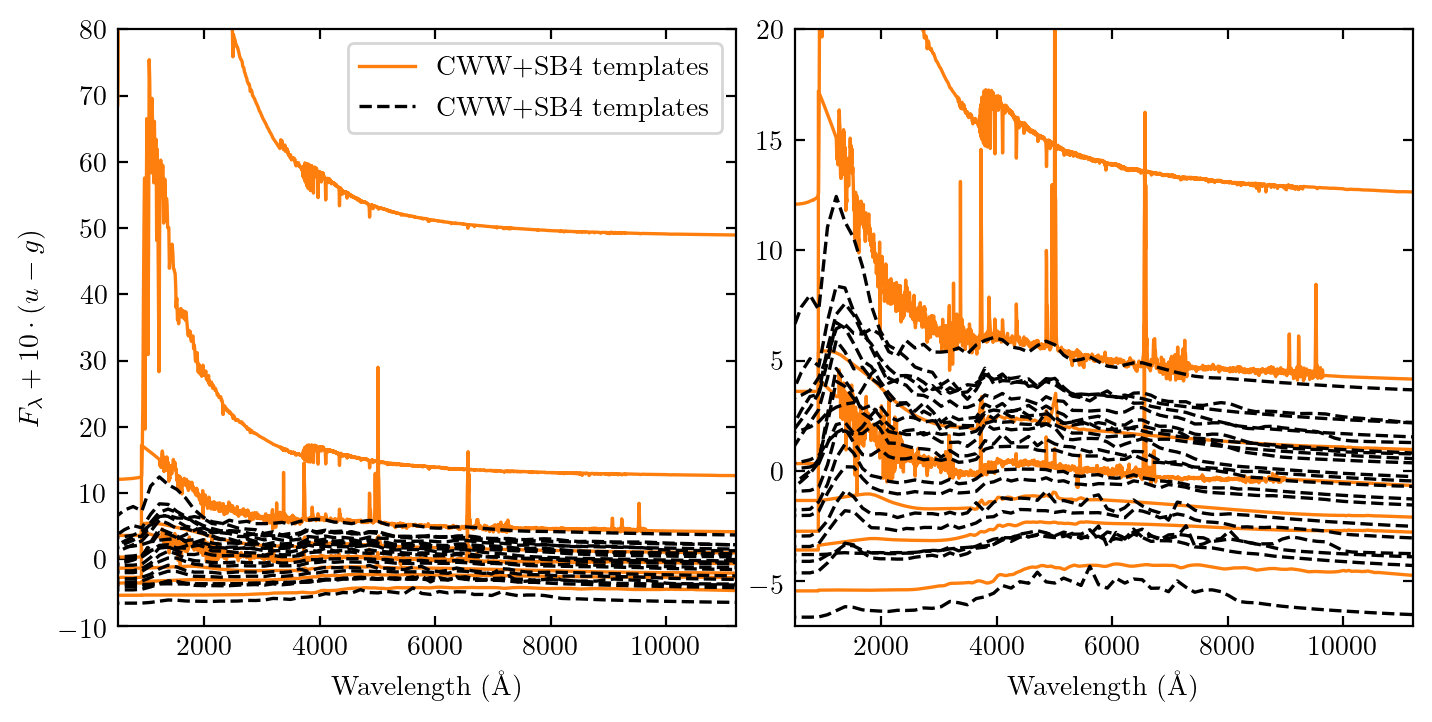

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(twocol,twocol/2))

colors = ['C1','k']
styles = ['-','--']
titles = ['CWW+SB4 templates', "Naive templates"]
for i,template_set in enumerate([cwwsb4,trained_templates]):

    for template in template_set:
        name = 'templates/'+template+'.sed'
        x,y = np.loadtxt(name,unpack=True)
        f = interp1d(x,y)
        y /= f(8000)

        sed = Sed()
        sed.wavelen = x
        sed.flambda = y

        u = sed.flux(bandpass_dict['u'])
        g = sed.flux(bandpass_dict['g'])
        template_fluxes = sed.fluxlist(bandpass_dict)
        
        ax1.plot(x,y+10*(u-g),c=colors[i],ls=styles[i])
        ax2.plot(x,y+10*(u-g),c=colors[i],ls=styles[i])

ax1.plot([5000],[30],c='C1',label='CWW+SB4 templates')
ax1.plot([5000],[30],c='k',ls='--',label='CWW+SB4 templates')
ax1.legend()

ax1.set_ylim(-10,80)
ax1.set_xlim(500,11200)
ax1.set_ylabel('$F_\lambda + 10 \cdot (u-g)$') 
ax1.set_xlabel('Wavelength ($\mathrm{\AA}$)')

ax2.set_ylim(-7,20)
ax2.set_xlim(500,11200)
ax2.set_xlabel('Wavelength ($\mathrm{\AA}$)')

fig.tight_layout(pad=0.5)
#fig.savefig("plots/naive_vs_cwwsb4.pdf")
plt.show()